# Experiment-3: Recommender System Based on Matrix Factorization
## In this experiment, we will: 
- (1) Get more intuitions about Matrix Decomposition. 
- (2) Get your hands dirty on MovieLens-100k dataset, which contains 100,000 comments from 943 users out of 1682 movies. 
- (3) Get some intuition about hidden dimension's impact.
- (4) Get some intuition about loss function's impact.
- (5) Get some intuition about regularizer's impact.
### As usual, in this experiment, we will use the mini framework [simple_ml](https://github.com/lizhaoliu-Lec/simple_ml).

In [1]:
# as usual, do a little setup
# upgration for Factorization layer.
%pip install --upgrade simple_machine_learning
import numpy as np

from simple_ml.nn.layer import Factorization, Input
from simple_ml.nn.model import Model
from simple_ml.nn.regularizer import L2_Regularizer, L1_Regularizer, L1L2_Regularizer
from simple_ml.nn.loss import MAE, MSE, HuberLoss
from simple_ml.nn.optimizer import SGD, Momentum, Adam, RMSProp
from simple_ml.utils.metric import absolute_error

import matplotlib.pyplot as plt

# fix random seed
np.random.seed(1234)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Requirement already up-to-date: simple_machine_learning in e:\anaconda3\lib\site-packages (0.1.5)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# load the data.

def read_data(data_path='../tmp/exp5/ml-100k/u.data', val_split=0.1, test_split=0.2):
    # read the data
    triples = []
    with open(data_path) as f:
        for line in f.readlines():
            triples.append([int(i) for i in line.split('\t')[:-1]])
    Data = np.array(triples, dtype=np.int)
    total_size = Data.shape[0]
    train_size = int(total_size - (val_split + test_split) * total_size)
    val_size = int(train_size + val_split * total_size)
    Data_train = Data[:train_size]
    Data_val = Data[train_size:val_size]
    Data_test = Data[val_size:]

    def data_to_Xy(data):
        # start from index 0
        return data[:, :-1] - 1, np.reshape(data[:, -1], (-1, 1))

    X_train, y_train = data_to_Xy(Data_train)
    X_val, y_val = data_to_Xy(Data_val)
    X_test, y_test = data_to_Xy(Data_test)

    num_user = len(np.unique(Data[:, 0]))
    num_item = len(np.unique(Data[:, 1]))
    print('Number of unique user: %d' % num_user)
    print('Number of unique item: %d' % num_item)
    print('X_train: ', X_train.shape, ' y_train: ', y_train.shape)
    print('X_val: ', X_val.shape, ' y_val: ', y_val.shape)
    print('X_test: ', X_test.shape, ' y_test: ', y_train.shape)
    print()
    return X_train, y_train, X_val, y_val, X_test, y_test, num_user, num_item

X_train, y_train, X_val, y_val, X_test, y_test, num_user, num_item = read_data()
print('We have `%d` training examples, `%d` validation examples and `%d` test examples' % (X_train.shape[0], X_val.shape[0],X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_val shape: ', X_val.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_val shape: ', y_val.shape, ', y_test shape: ', y_test.shape)

Number of unique user: 943
Number of unique item: 1682
X_train:  (70000, 2)  y_train:  (70000, 1)
X_val:  (10000, 2)  y_val:  (10000, 1)
X_test:  (20000, 2)  y_test:  (70000, 1)

We have `70000` training examples, `10000` validation examples and `20000` test examples
X_train shape:  (70000, 2) , X_val shape:  (10000, 2) , X_test shape:  (20000, 2)
y_train shape:  (70000, 1) , y_val shape:  (10000, 1) , y_test shape:  (20000, 1)


## Hidden dimension's impact.
Now, we explore the impact of hiddent dimension in Matrix Factrization (MF). specifically, we set $h$ in [1, 5, 10, 15, 20, 25, 30].

In [3]:
# first define Matrix Factization model.
def MF(h=10, loss_fn=MSE, reg=L2_Regularizer, penalty_coff=0.1):
    Inputs = Input(input_shape=2)
    out = Factorization(a_dim=num_user, b_dim=num_item, k=h,
                        use_bias=True,
                        regularizer=reg(penalty_coff))(Inputs)
    # out = Factorization(a_dim=num_user, b_dim=num_item, k=10)(Inputs)
    model = Model(Inputs, out)
    # model.compile('MSE', optimizer=Adam(lr=0.001))
    model.compile(loss_fn(), optimizer=Adam(lr=0.001))
    return model


********** begin with hidden_dim = 1 **********

epoch   100/  200, train-[loss: 0.4174 | metric: 0.7262]; valid-[loss: 0.4483 | metric: 0.7537]; 
valid-example 1/5: expect-[2.0], predict-[1.96]
valid-example 2/5: expect-[4.0], predict-[3.3]
valid-example 3/5: expect-[4.0], predict-[4.44]
valid-example 4/5: expect-[1.0], predict-[3.37]
valid-example 5/5: expect-[4.0], predict-[2.31]

epoch   200/  200, train-[loss: 0.4123 | metric: 0.7214]; valid-[loss: 0.4477 | metric: 0.7525]; 
valid-example 1/5: expect-[2.0], predict-[2.65]
valid-example 2/5: expect-[5.0], predict-[2.03]
valid-example 3/5: expect-[4.0], predict-[3.48]
valid-example 4/5: expect-[4.0], predict-[2.88]
valid-example 5/5: expect-[2.0], predict-[3.62]

********** begin with hidden_dim = 5 **********

epoch   100/  200, train-[loss: 0.3184 | metric: 0.6290]; valid-[loss: 0.4348 | metric: 0.7336]; 
valid-example 1/5: expect-[4.0], predict-[4.49]
valid-example 2/5: expect-[3.0], predict-[1.91]
valid-example 3/5: expect-[1.0

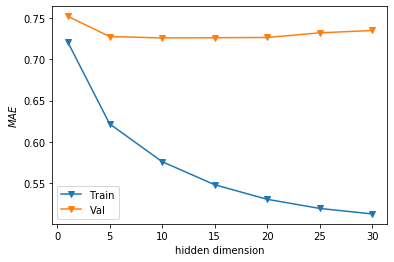

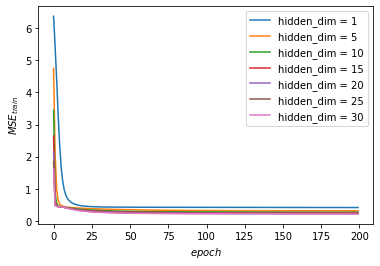

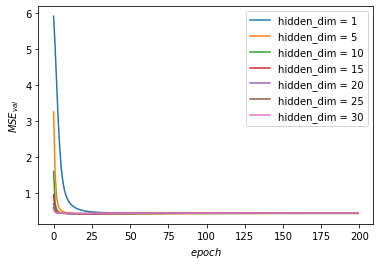

In [5]:
hs = [1, 5, 10, 15, 20, 25, 30]
h2tr_mae = []
h2val_mae = []
h2tr_losses = []
h2val_losses = []

for h in hs:
    print()
    print(10*'*' + ' begin with hidden_dim = %d ' % h + 10*'*')
    model = MF(h=h)
    model.fit(X_train, y_train,
              verbose=100, epochs=200,
              validation_data=(X_val, y_val),
              batch_size=256, metric='MAE',
              shuffle=True,
              peek_type='single-reg')
    train_y_hat = model.forward(X_train)
    val_y_hat = model.forward(X_val)
    training_error = absolute_error(y_train, train_y_hat) / y_train.shape[0]
    val_error = absolute_error(y_val, val_y_hat) / y_val.shape[0]
    
    performance = model.best_performance(bigger=False)
    
    h2tr_mae.append(performance['train_set']['best_metric'])
    h2val_mae.append(performance['val_set']['best_metric'])
    
    h2tr_losses.append(model.train_losses)
    h2val_losses.append(model.validation_losses)
    
plt.plot(hs, h2tr_mae, label='Train', marker='v')
plt.plot(hs, h2val_mae, label='Val', marker='v')
plt.legend()
plt.xlabel('hidden dimension')
plt.ylabel('$MAE$')
plt.savefig('h_mae.png', dpi=300)
plt.show()

for idx in range(len(h2tr_losses)):
    plt.plot(h2tr_losses[idx], label='hidden_dim = %d' % hs[idx])
plt.legend()
plt.ylabel('$MSE_{train}$')
plt.xlabel('$epoch$')
plt.savefig('h_tr_losses.png', dpi=300)
plt.show()

for idx in range(len(h2val_losses)):
    plt.plot(h2val_losses[idx], label='hidden_dim = %d' % hs[idx])
plt.legend()
plt.ylabel('$MSE_{val}$')
plt.xlabel('$epoch$')
plt.savefig('h_val_losses.png', dpi=300)
plt.show()

Now we print out the performance of MF under different $h$ in both training set and validation set. 

In [6]:
for idx in range(len(hs)):
    print('hidden dim: %d, training MAE: %.4f, val MAE: %.4f.' % (hs[idx], h2tr_mae[idx], h2val_mae[idx]))

hidden dim: 1, training MAE: 0.7211, val MAE: 0.7522.
hidden dim: 5, training MAE: 0.6216, val MAE: 0.7276.
hidden dim: 10, training MAE: 0.5758, val MAE: 0.7259.
hidden dim: 15, training MAE: 0.5478, val MAE: 0.7262.
hidden dim: 20, training MAE: 0.5302, val MAE: 0.7265.
hidden dim: 25, training MAE: 0.5191, val MAE: 0.7321.
hidden dim: 30, training MAE: 0.5124, val MAE: 0.7349.


## Loss function's impact.
Now, we explore the impact of loss function in Matrix Factrization (MF). specifically, we set $loss_fn$ in [MAE, MSE, HB], where HB is huber loss.
1. $MAE(y, \hat{y}) = \frac{1}{m}\Sigma_{i=1}^{m}|y_i - \hat{y_i}|$ 

2. $MSE(y, \hat{y}) = \frac{1}{2m}\Sigma_{i=1}^{m}(y_i - \hat{y_i})^2$ 

3. $HB(y, \hat{y}) = \frac{1}{m}\Sigma_{i=1}^{m}L_{\delta }(y_i, \hat{y_i}) $ 
where, $ L_{\delta }(y_i,\hat{y_i})={\begin{cases}{\frac  {1}{2}}(y_i-\hat{y_i})^{2}&{\textrm  {for}}~|y_i-\hat{y_i}|\leq \delta ,\\\delta \,|y_i-\hat{y_i}|-{\frac  {1}{2}}\delta ^{2}&{\textrm  {otherwise.}}\end{cases}}$ 

We set $\delta = 1.$.

We first draw the three loss function e.g. $MAE(x)$, $MSE(x)$ and $HB(x)$.

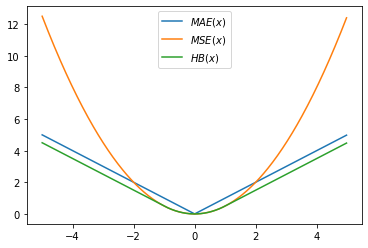

In [20]:
def mae(x):
    return np.abs(x)

def mse(x):
    return 0.5 * x ** 2

def hb(x):
    inner_part = np.abs(x) <= 1
    outer_part = np.abs(x) > 1
    return inner_part * 0.5 * x **2 + outer_part * (np.abs(x) - 0.5)


x = np.arange(-5, 5, 0.02)
plt.plot(x, mae(x), label='$MAE(x)$')
plt.plot(x, mse(x), label='$MSE(x)$')
plt.plot(x, hb(x), label='$HB(x)$')
plt.legend()
plt.savefig('loss_fns.png', dpi=300)
plt.show()


********** begin with loss_fn = <class 'simple_ml.nn.loss.MeanAbsoluteLoss'> **********

epoch   100/  200, train-[loss: 0.5399 | metric: 0.5399]; valid-[loss: 0.7488 | metric: 0.7488]; 
valid-example 1/5: expect-[3.0], predict-[3.98]
valid-example 2/5: expect-[4.0], predict-[4.43]
valid-example 3/5: expect-[3.0], predict-[3.99]
valid-example 4/5: expect-[2.0], predict-[2.85]
valid-example 5/5: expect-[4.0], predict-[3.4]

epoch   200/  200, train-[loss: 0.5222 | metric: 0.5222]; valid-[loss: 0.7579 | metric: 0.7579]; 
valid-example 1/5: expect-[3.0], predict-[3.01]
valid-example 2/5: expect-[4.0], predict-[4.93]
valid-example 3/5: expect-[2.0], predict-[3.55]
valid-example 4/5: expect-[4.0], predict-[4.51]
valid-example 5/5: expect-[2.0], predict-[3.63]

********** begin with loss_fn = <class 'simple_ml.nn.loss.MeanSquareLoss'> **********

epoch   100/  200, train-[loss: 0.2753 | metric: 0.5835]; valid-[loss: 0.4395 | metric: 0.7355]; 
valid-example 1/5: expect-[3.0], predict-[3.42]


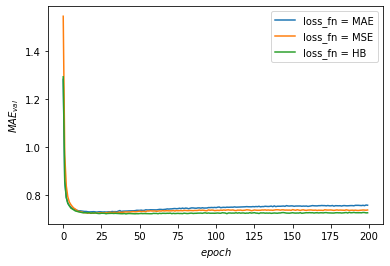

In [9]:
loss_fns = [MAE, MSE, HuberLoss]
loss_name = ['MAE', 'MSE', 'HB']
loss2valmetrices = []
loss2val_best_metric = []

for loss in loss_fns:
    print()
    print(10*'*' + ' begin with loss_fn = %s ' % str(loss) + 10*'*')
    model = MF(loss_fn=loss)
    model.fit(X_train, y_train,
              verbose=100, epochs=200,
              validation_data=(X_val, y_val),
              batch_size=256, metric='MAE',
              shuffle=True,
              peek_type='single-reg')
    
    performance = model.best_performance(bigger=False)
    
    loss2val_best_metric.append(performance['val_set']['best_metric'])
    
    loss2valmetrices.append(model.validation_metrics)

for idx in range(len(loss_fns)):
    plt.plot(loss2valmetrices[idx], label='loss_fn = %s' % loss_name[idx])
plt.legend()
plt.ylabel('$MAE_{val}$')
plt.xlabel('$epoch$')
plt.savefig('loss_val_mae.png', dpi=300)
plt.show()

Now we print out the performance of MF under different $loss_{fn}$ in validation set. 

In [24]:
for idx in range(len(loss_fns)):
    print('Loss func: %s, Val Mae: %.4f' % (str(loss_fns[idx]), loss2val_best_metric[idx]))

Loss func: <class 'simple_ml.nn.loss.MeanAbsoluteLoss'>, Val Mae: 0.7293
Loss func: <class 'simple_ml.nn.loss.MeanSquareLoss'>, Val Mae: 0.7244
Loss func: <class 'simple_ml.nn.loss.HuberLoss'>, Val Mae: 0.7217


## Regularizer's impact.
Now, we explore the impact of regularizer in Matrix Factrization (MF). specifically, we set $reg$ in [L1, L2, L1_L2].

We first draw the three loss function e.g. $L1(x)$, $L2(x)$ and $L1\_L2(x)$. With penalty cofficient = 0.01.

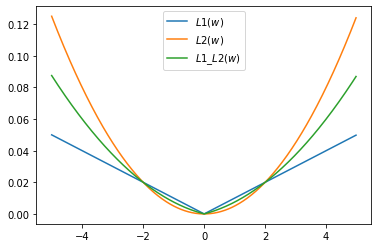

In [22]:
def l1(x, l=0.01):
    return l * np.abs(x)

def l2(x, l=0.01):
    return l * 0.5 * x ** 2

def l1_l2(x, l=0.01):
    return 0.5 * l1(x, l) + 0.5 * l2(x, l)


x = np.arange(-5, 5, 0.02)
plt.plot(x, l1(x), label='$L1(w)$')
plt.plot(x, l2(x), label='$L2(w)$')
plt.plot(x, l1_l2(x), label='$L1\_ L2(w)$')
plt.legend()
plt.savefig('regs.png', dpi=300)
plt.show()


********** begin with reg = <class 'simple_ml.nn.regularizer.L1'> **********

epoch   100/  200, train-[loss: 0.4336 | metric: 0.7396]; valid-[loss: 0.4513 | metric: 0.7565]; 
valid-example 1/5: expect-[5.0], predict-[3.17]
valid-example 2/5: expect-[2.0], predict-[2.55]
valid-example 3/5: expect-[3.0], predict-[2.51]
valid-example 4/5: expect-[4.0], predict-[3.04]
valid-example 5/5: expect-[5.0], predict-[2.48]

epoch   200/  200, train-[loss: 0.4335 | metric: 0.7397]; valid-[loss: 0.4518 | metric: 0.7572]; 
valid-example 1/5: expect-[5.0], predict-[4.7]
valid-example 2/5: expect-[5.0], predict-[4.31]
valid-example 3/5: expect-[4.0], predict-[3.35]
valid-example 4/5: expect-[3.0], predict-[3.79]
valid-example 5/5: expect-[3.0], predict-[2.79]

********** begin with reg = <class 'simple_ml.nn.regularizer.L2'> **********

epoch   100/  200, train-[loss: 0.2742 | metric: 0.5822]; valid-[loss: 0.4402 | metric: 0.7390]; 
valid-example 1/5: expect-[4.0], predict-[3.9]
valid-example 2/5: ex

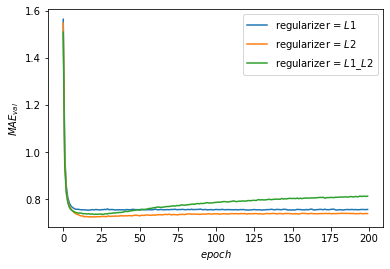

In [28]:
regs = [L1_Regularizer, L2_Regularizer, L1L2_Regularizer]
reg_names = ['L1', 'L2', 'L1\_L2']
reg2valmetrices = []
reg2val_best_metric = []

for reg in regs:
    print()
    print(10*'*' + ' begin with reg = %s ' % str(reg) + 10*'*')
    model = MF(reg=reg)
    model.fit(X_train, y_train,
              verbose=100, epochs=200,
              validation_data=(X_val, y_val),
              batch_size=256, metric='MAE',
              shuffle=True,
              peek_type='single-reg')
    
    performance = model.best_performance(bigger=False)
    
    reg2val_best_metric.append(performance['val_set']['best_metric'])
    
    reg2valmetrices.append(model.validation_metrics)

for idx in range(len(regs)):
    plt.plot(reg2valmetrices[idx], label='regularizer = $%s$' % reg_names[idx])
plt.legend()
plt.ylabel('$MAE_{val}$')
plt.xlabel('$epoch$')
plt.savefig('reg_val_mae.png', dpi=300)
plt.show()

Now we print out the performance of MF under different $reg$ in validation set. 

In [27]:
for idx in range(len(regs)):
    print('Reg: %s, Val Mae: %.4f' % (str(regs[idx]), reg2val_best_metric[idx]))

Reg: <class 'simple_ml.nn.regularizer.L1'>, Val Mae: 0.7537
Reg: <class 'simple_ml.nn.regularizer.L2'>, Val Mae: 0.7243
Reg: <class 'simple_ml.nn.regularizer.L1L2'>, Val Mae: 0.7358


##  Final performance

In [33]:
print(10 * '*' + ' begin with best MF ' + 10 * '*')
model = MF(h=10, reg=L2_Regularizer, loss_fn=HuberLoss)
model.fit(X_train, y_train,
          verbose=19, epochs=38,
          validation_data=(X_val, y_val),
          batch_size=256, metric='MAE',
          shuffle=True,
          peek_type='single-reg')
train_y_hat = model.forward(X_train)
val_y_hat = model.forward(X_val)
test_y_hat = model.forward(X_test)
training_error = absolute_error(y_train, train_y_hat) / y_train.shape[0]
val_error = absolute_error(y_val, val_y_hat) / y_val.shape[0]
test_error = absolute_error(y_test, test_y_hat) / y_test.shape[0]

print()
print('Training MAE: %.4f' % training_error)
print('Val MAE: %.4f' % val_error)
print('Test MAE: %.4f' % test_error)

********** begin with best MF **********

epoch    19/   38, train-[loss: 0.3310 | metric: 0.6792]; valid-[loss: 0.3666 | metric: 0.7251]; 
valid-example 1/5: expect-[4.0], predict-[3.55]
valid-example 2/5: expect-[5.0], predict-[4.51]
valid-example 3/5: expect-[2.0], predict-[2.68]
valid-example 4/5: expect-[4.0], predict-[4.27]
valid-example 5/5: expect-[5.0], predict-[3.89]

epoch    38/   38, train-[loss: 0.3062 | metric: 0.6475]; valid-[loss: 0.3662 | metric: 0.7246]; 
valid-example 1/5: expect-[4.0], predict-[3.16]
valid-example 2/5: expect-[5.0], predict-[3.94]
valid-example 3/5: expect-[4.0], predict-[2.89]
valid-example 4/5: expect-[1.0], predict-[2.81]
valid-example 5/5: expect-[4.0], predict-[3.96]

Training MAE: 0.6342
Val MAE: 0.7246
Test MAE: 0.7294
